# Testing out the SAM Model

GitHub: https://github.com/facebookresearch/segment-anything

## Predictor

In [2]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import cv2

In [40]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else: 
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white') 
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white') 

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [4]:
image = cv2.imread('test_image.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

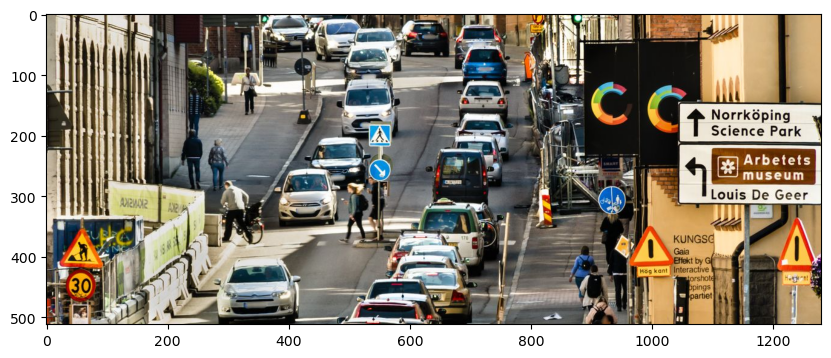

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Create the SAM Model Object

In [11]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cpu" # "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
model_type = "default"

Using: cpu


In [12]:
from segment_anything import sam_model_registry, SamPredictor 

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [13]:
predictor = SamPredictor(sam)
predictor.set_image(image)

## Select out Point

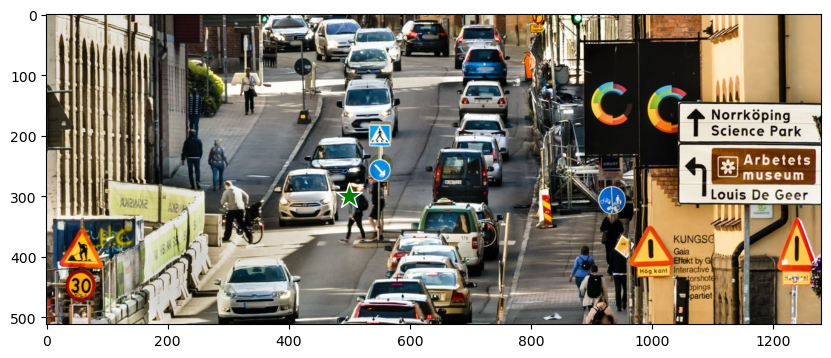

In [30]:
input_point = np.array([[500, 300]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [46]:
masks, scores, logits = predictor.predict(point_coords=input_point,
                  point_labels=input_label,
                  multimask_output=True) # Can find multiple masks for this region

In [39]:
masks.shape # (number of masks, height, width)

(3, 512, 1280)

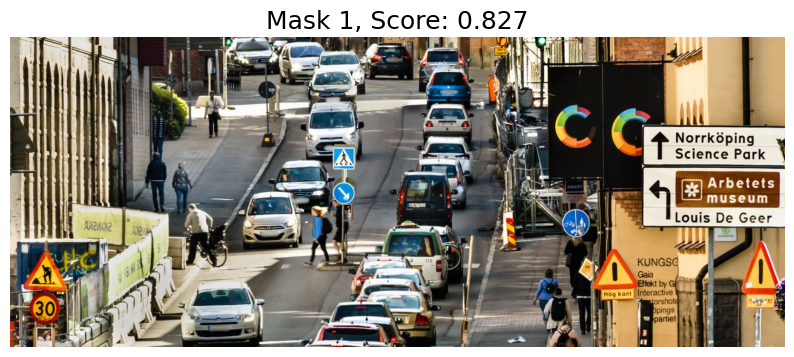

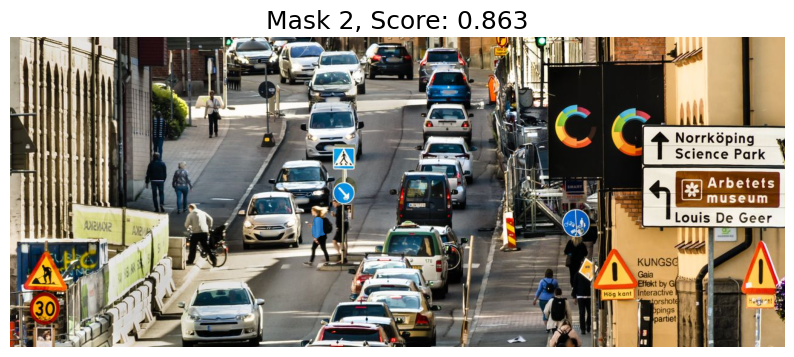

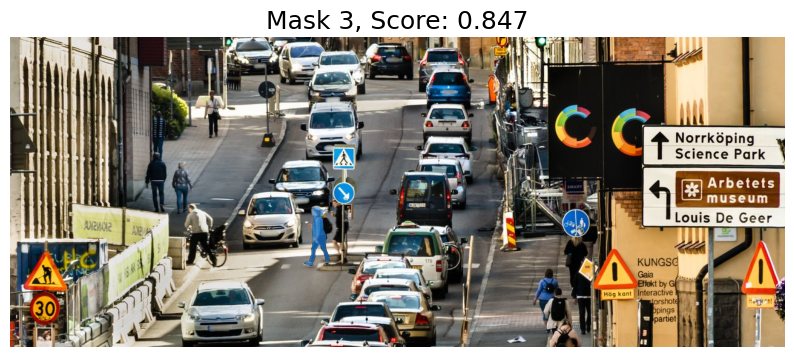

In [47]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10 ))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

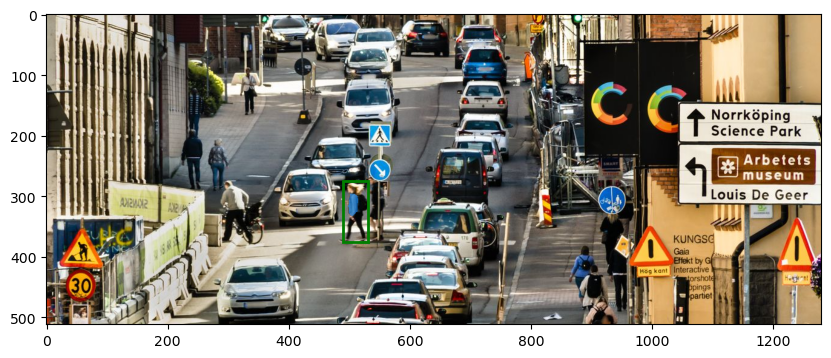

In [62]:
input_box = np.array([490, 275, 530, 375])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

In [72]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False
)

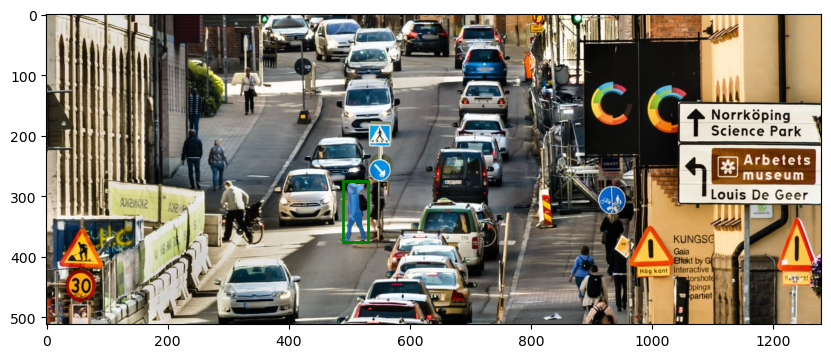

In [73]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

## Auto Segmentation

In [78]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor 
device = "cpu" # Didn't work with mps
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [79]:
masks = mask_generator.generate(image) # Quite slow at 48.3s on cpu. 

In [81]:
len(masks)

176

In [82]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


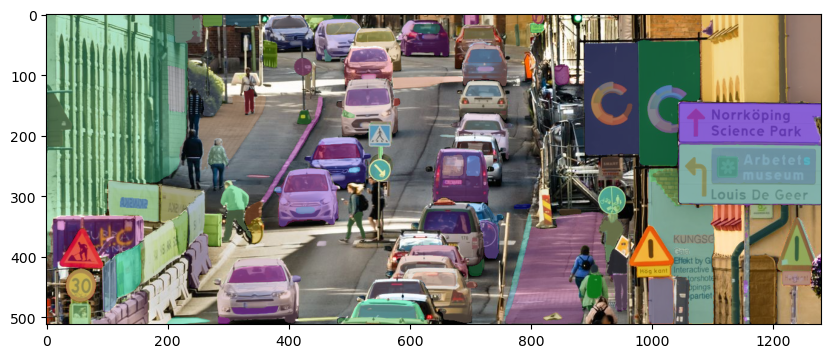

In [83]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('on')
plt.show()